# **MLP with extended physics loss function (Option 2: PDEs)**
# DUMMY FOR FAMILARISING
## Experiment using basic pde like y' = ky + a for loss func

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

## **Computing y_phy with MLP**

## Manual Method (without libraries)

### Defining MLP for y_phy

In [4]:
# Define MLP model
class MLP_phy(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_phy, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [5]:
def compute_pde_phy_loss(y_pred, t_train, k=2, a=3):
    """
    Compute PDE-based loss using automatic differentiation for y' = k*y + a.
    
    Parameters:
    - y_pred: Model's predicted values
    - t_train: Time input (requires gradient for autograd)
    - k: Coefficient in the PDE (default: 2)
    - a: Constant term in the PDE (default: 3)
    
    Returns:
    - Physics-based PDE loss
    """
    # Compute dy/dt using autograd
    dy_dt = torch.autograd.grad(y_pred, t_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # Define PDE loss: dy/dt - (k*y + a) = 0  ->  should be minimized
    # mean squared error
    loss_pde = torch.mean((dy_dt - (k * y_pred + a)) ** 2) + torch.mean((y_pred[0] - 1) ** 2)
    
    return loss_pde


In [6]:
def compute_pde_phy_loss_2nd(y_pred, t_train):
    """
    Compute physics-informed loss for d²u/dt² + u = 0.
    """
    # Compute first derivative du/dt
    du_dt = torch.autograd.grad(y_pred, t_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # Compute second derivative d²u/dt²
    d2u_dt2 = torch.autograd.grad(du_dt, t_train, grad_outputs=torch.ones_like(du_dt), create_graph=True)[0]

    # PDE loss: d²u/dt² + u = 0  (should be minimized)
    loss_pde = torch.mean((d2u_dt2 + y_pred) ** 2)

    # Initial condition losses
    loss_ic_u = (y_pred[0] - 1) ** 2  # u(0) = 1
    loss_ic_du = (du_dt[0] - 0) ** 2  # u'(0) = 0

    return loss_pde + loss_ic_u + loss_ic_du


In [7]:
# Training parameters
num_epochs = 2000
learning_rate = 0.01
input_size = 1  # t as input
hidden_size = 10
output_size = 1

# Generate synthetic training data
t = torch.linspace(0, 10, 100).view(-1, 1)  # Time values

# Initialize model, optimizer
model = MLP_phy(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop using only the PDE loss
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Randomly perturb training points to improve generalization
    epsilon = torch.normal(0, 0.1, size=t.shape)
    t_train = (t + epsilon).requires_grad_(True)  # Require gradient for PDE loss

    # Forward pass
    y_pred = model(t_train)

    # Compute PDE loss
    loss = compute_pde_phy_loss_2nd(y_pred, t_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, PDE Loss: {loss.item()}")

print("Training complete.")
print("Model parameters:")
for name, param in model.named_parameters():
    print(name, param.data)

Epoch 0, PDE Loss: 1.1978164911270142
Epoch 100, PDE Loss: 0.12702436745166779
Epoch 200, PDE Loss: 0.17527276277542114
Epoch 300, PDE Loss: 0.16469135880470276
Epoch 400, PDE Loss: 0.18992945551872253
Epoch 500, PDE Loss: 0.16301408410072327
Epoch 600, PDE Loss: 0.1711432933807373
Epoch 700, PDE Loss: 0.17642802000045776
Epoch 800, PDE Loss: 0.15664620697498322
Epoch 900, PDE Loss: 0.16322961449623108
Epoch 1000, PDE Loss: 0.15957434475421906
Epoch 1100, PDE Loss: 0.17380774021148682
Epoch 1200, PDE Loss: 0.1702146828174591
Epoch 1300, PDE Loss: 0.162420392036438
Epoch 1400, PDE Loss: 0.18788982927799225
Epoch 1500, PDE Loss: 0.16491085290908813
Epoch 1600, PDE Loss: 0.18872079253196716
Epoch 1700, PDE Loss: 0.17043142020702362
Epoch 1800, PDE Loss: 0.16087916493415833
Epoch 1900, PDE Loss: 0.16117675602436066
Training complete.
Model parameters:
hidden.weight tensor([[-0.9691],
        [ 0.3107],
        [ 0.4534],
        [-0.1889],
        [ 0.1770],
        [-0.9502],
        [-0.

tensor([[ 0.0000],
        [ 0.1010],
        [ 0.2020],
        [ 0.3030],
        [ 0.4040],
        [ 0.5051],
        [ 0.6061],
        [ 0.7071],
        [ 0.8081],
        [ 0.9091],
        [ 1.0101],
        [ 1.1111],
        [ 1.2121],
        [ 1.3131],
        [ 1.4141],
        [ 1.5152],
        [ 1.6162],
        [ 1.7172],
        [ 1.8182],
        [ 1.9192],
        [ 2.0202],
        [ 2.1212],
        [ 2.2222],
        [ 2.3232],
        [ 2.4242],
        [ 2.5253],
        [ 2.6263],
        [ 2.7273],
        [ 2.8283],
        [ 2.9293],
        [ 3.0303],
        [ 3.1313],
        [ 3.2323],
        [ 3.3333],
        [ 3.4343],
        [ 3.5354],
        [ 3.6364],
        [ 3.7374],
        [ 3.8384],
        [ 3.9394],
        [ 4.0404],
        [ 4.1414],
        [ 4.2424],
        [ 4.3434],
        [ 4.4444],
        [ 4.5455],
        [ 4.6465],
        [ 4.7475],
        [ 4.8485],
        [ 4.9495],
        [ 5.0505],
        [ 5.1515],
        [ 5.

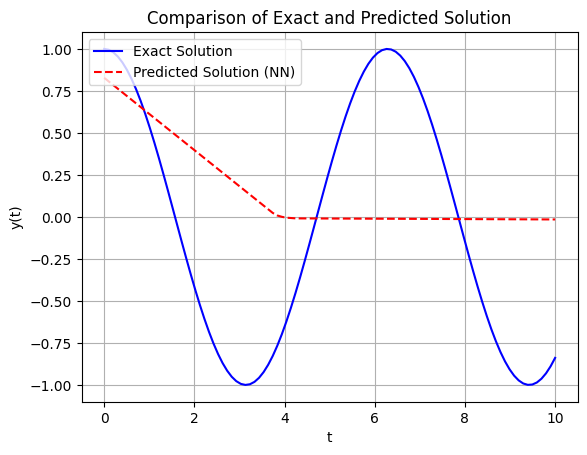

In [8]:
import matplotlib.pyplot as plt
# Generate the true solution
t_values = np.linspace(0, 10, 100)
# y_exact = (5/2) * np.exp(2 * t_values) - 3/2  # Exact solution y(t) = 5/2 * e^(2t) - 3/2
# Predict using the trained model
y_exact = np.cos(t_values)
t_tensor = torch.tensor(t_values, dtype=torch.float32).view(-1, 1)
print(t_tensor)
y_pred = model(t_tensor).detach().numpy()  # Get the predicted values

# Plot the results
plt.plot(t_values, y_exact, label="Exact Solution", color='blue')
plt.plot(t_values, y_pred, label="Predicted Solution (NN)", color='red', linestyle='--')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Comparison of Exact and Predicted Solution')
plt.grid(True)
plt.show()

## Using neurodiffeq

In [8]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
# equation is dy/dt = 2y, y(0) = 1
exponential = lambda u, t: diff(u, t) - 2 * u # specify the ODE
init_val_ex = IVP(t_0=0.0, u_0=1.0)       # specify the initial conditon

# solve the ODE
solution_ex, loss_ex = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2
)

/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/neurodiffeq/ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

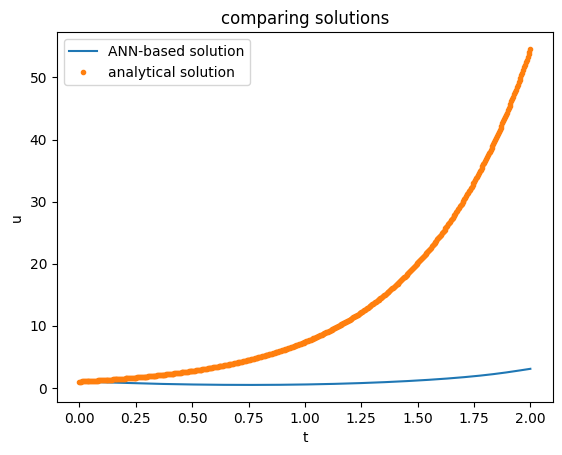

In [10]:
import matplotlib.pyplot as plt
ts = np.linspace(0, 2, 500)
u_net = solution_ex(ts, to_numpy=True)
u_ana = np.exp(2 * ts)

plt.figure()
plt.plot(ts, u_net, label='ANN-based solution')
plt.plot(ts, u_ana, '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

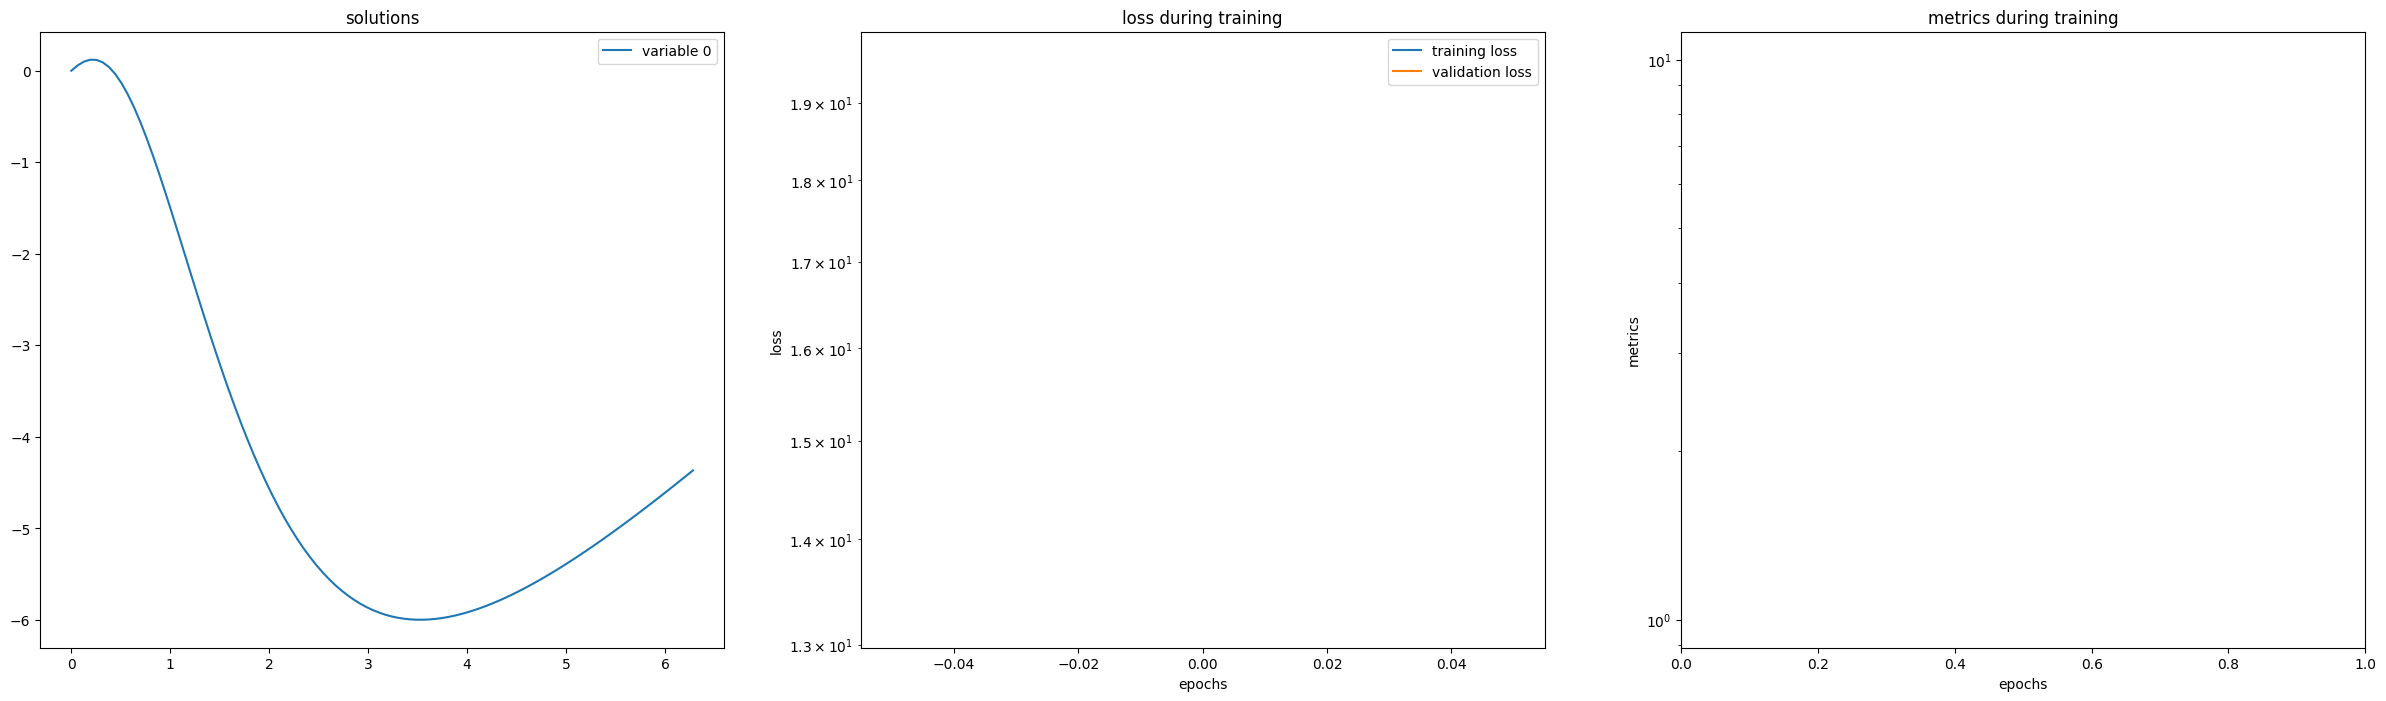

In [13]:
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.callbacks import MonitorCallback

w_squared = 1

def ode_harmonic(u, t):
    return [diff(u, t, order=2) + w_squared*u,]

condition_harmonic = [IVP(t_0=0, u_0=0, u_0_prime=1),]

net = [FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(1024,1024),
    actv=torch.nn.Tanh
),]

solver_harmonic = Solver1D(
    ode_system=ode_harmonic,
    conditions=condition_harmonic,
    t_min=0.0,
    t_max=2*np.pi,
    nets=net
)
monitor = Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
monitor_callback = MonitorCallback(monitor)

solver_harmonic.fit(max_epochs=2000, callbacks=[monitor_callback])
solution_harmonic = solver_harmonic.get_solution()

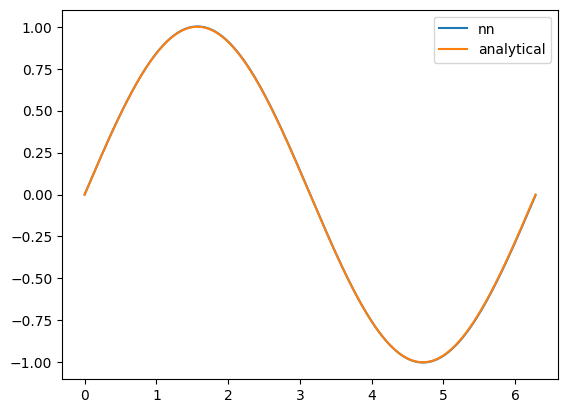

In [14]:
t = np.linspace(0, 2*np.pi, 10000)
s = solution_harmonic(t, to_numpy=True)

%matplotlib inline
plt.plot(t, s, label='nn')
plt.plot(t, np.sin(t), label='analytical')
plt.legend()
plt.show()

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

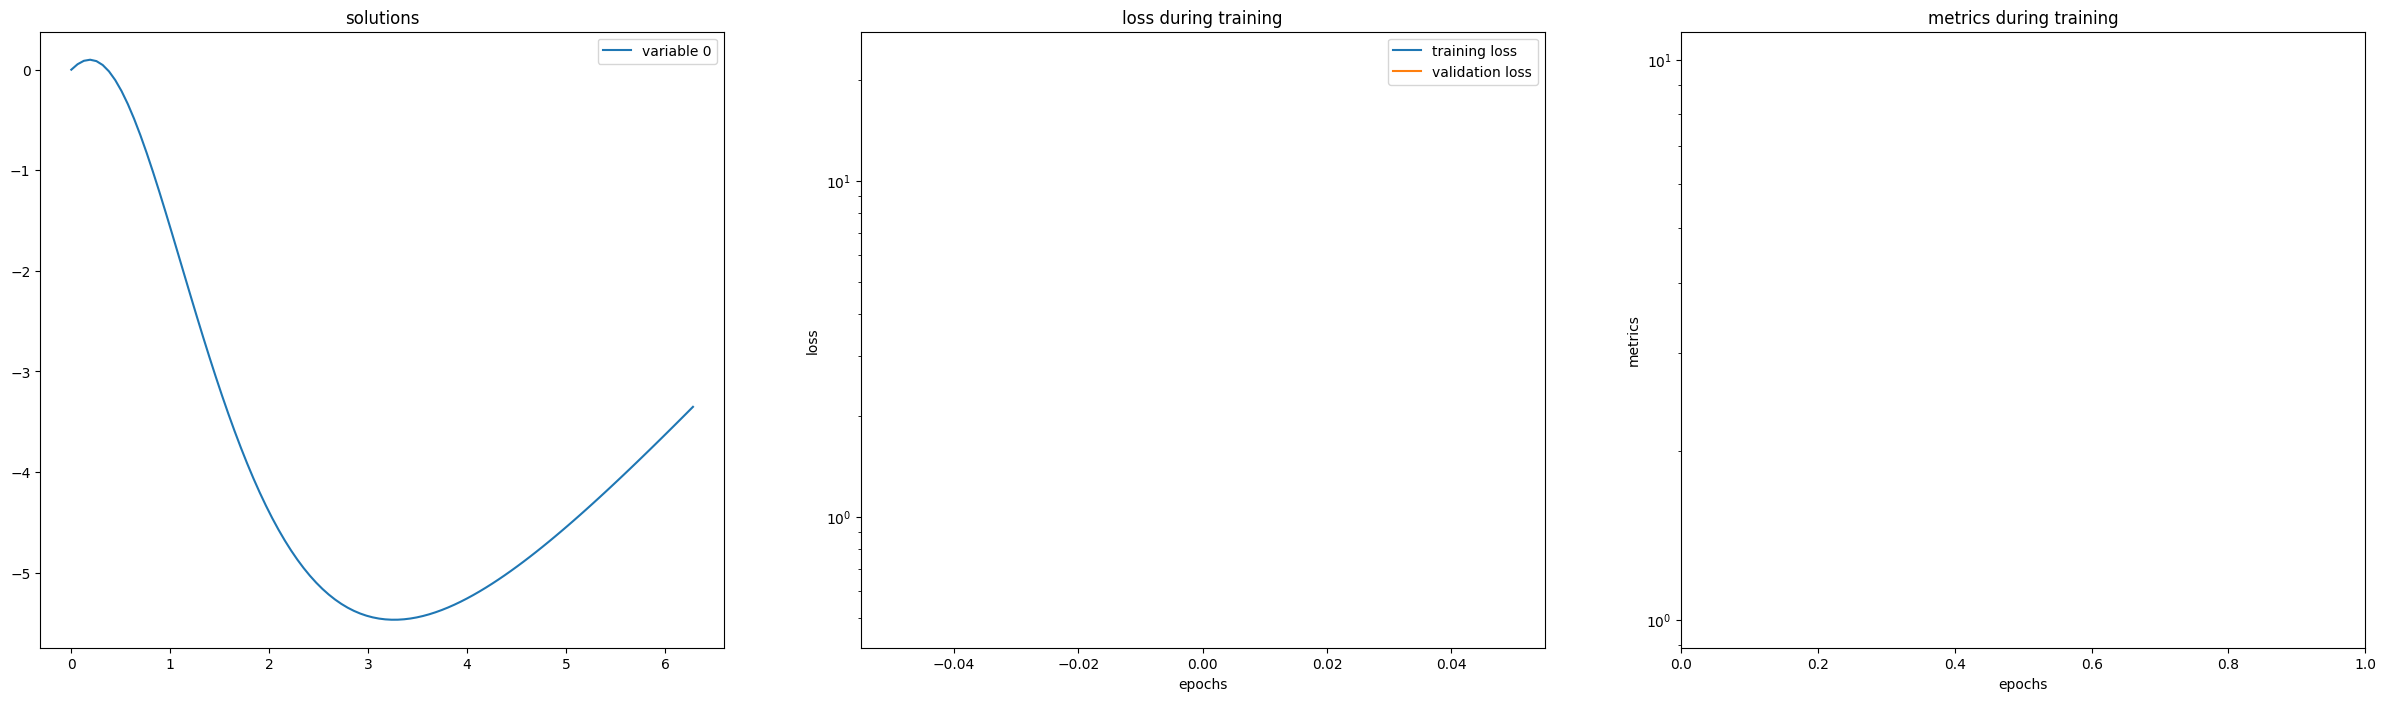

In [ ]:
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.callbacks import MonitorCallback

w_squared = 1

def ode_harmonic(u, t):
    return [diff(u, t, order=2) + w_squared*u]

condition_harmonic = [IVP(t_0=0, u_0=0, u_0_prime=1),]

net = [FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(1024,1024),
    actv=torch.nn.Tanh
),]

solver_harmonic = Solver1D(
    ode_system=ode_harmonic,
    conditions=condition_harmonic,
    t_min=0.0,
    t_max=1,
    nets=net
)
monitor = Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
monitor_callback = MonitorCallback(monitor)

solver_harmonic.fit(max_epochs=2000, callbacks=[monitor_callback])
solution_harmonic = solver_harmonic.get_solution()

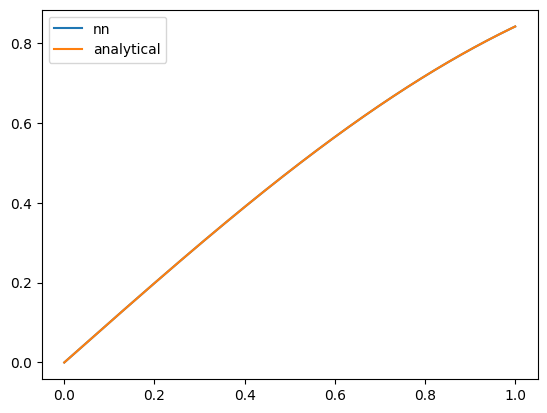

In [16]:
t = np.linspace(0, 1, 10000)
s = solution_harmonic(t, to_numpy=True)

%matplotlib inline
plt.plot(t, s, label='nn')
plt.plot(t, np.sin(t), label='analytical')
plt.legend()
plt.show()

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

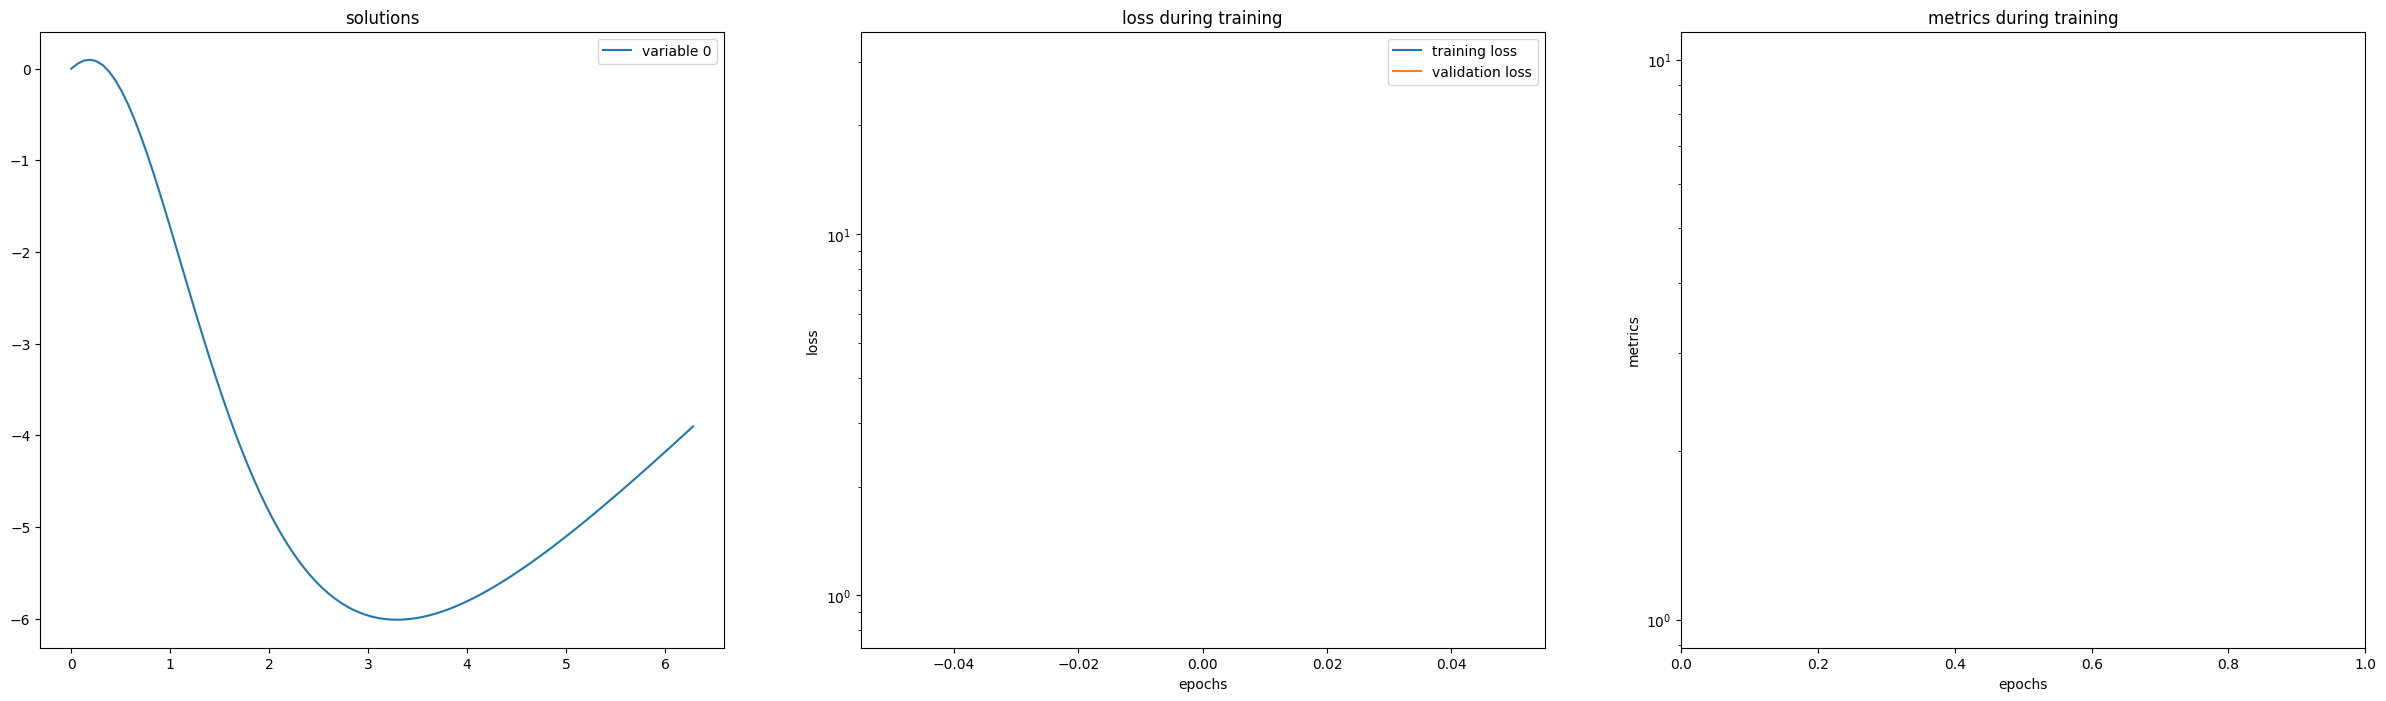

In [18]:
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.callbacks import MonitorCallback

w_squared = 2

def ode_harmonic(u, t):
    return [diff(u, t, order=2) + w_squared*u,]

condition_harmonic = [IVP(t_0=0, u_0=0, u_0_prime=1),]

net = [FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(1024,1024),
    actv=torch.nn.Tanh
),]

solver_harmonic = Solver1D(
    ode_system=ode_harmonic,
    conditions=condition_harmonic,
    t_min=0.0,
    t_max=1,
    nets=net
)
monitor = Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
monitor_callback = MonitorCallback(monitor)

solver_harmonic.fit(max_epochs=2000, callbacks=[monitor_callback])
solution_harmonic = solver_harmonic.get_solution()

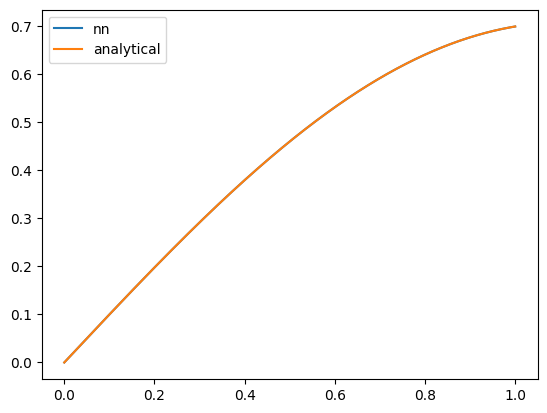

In [19]:
t = np.linspace(0, 1, 10000)
s = solution_harmonic(t, to_numpy=True)
u_true = (1/np.sqrt(2)) * np.sin(np.sqrt(2) * t)

%matplotlib inline
plt.plot(t, s, label='nn')
plt.plot(t, u_true, label='analytical')
plt.legend()
plt.show()

In [6]:
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver2D
from neurodiffeq.generators import Generator2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition


def pde_advection(u, x, y):
    return [diff(u, x) + diff(u, y)]


conditions_advection = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: y,  # u(0, y) = y
        x_max=1, x_max_val=lambda y: y,  # u(1, y) = y
        y_min=0, y_min_val=lambda x: 0,  # u(x, 0) = 0
        y_max=1, y_max_val=lambda x: 1,  # u(x, 1) = 1
    )
]



nets_advection = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
]

monitor_advection = Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = MonitorCallback(monitor_advection)

solver_advection = Solver2D(
    pde_system=pde_advection,
    conditions=conditions_advection,
    nets=nets_advection,
    xy_min=(0, 0),
    xy_max=(1, 1),
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

solver_advection.fit(max_epochs=1000)
solution_advection = solver_advection.get_solution()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

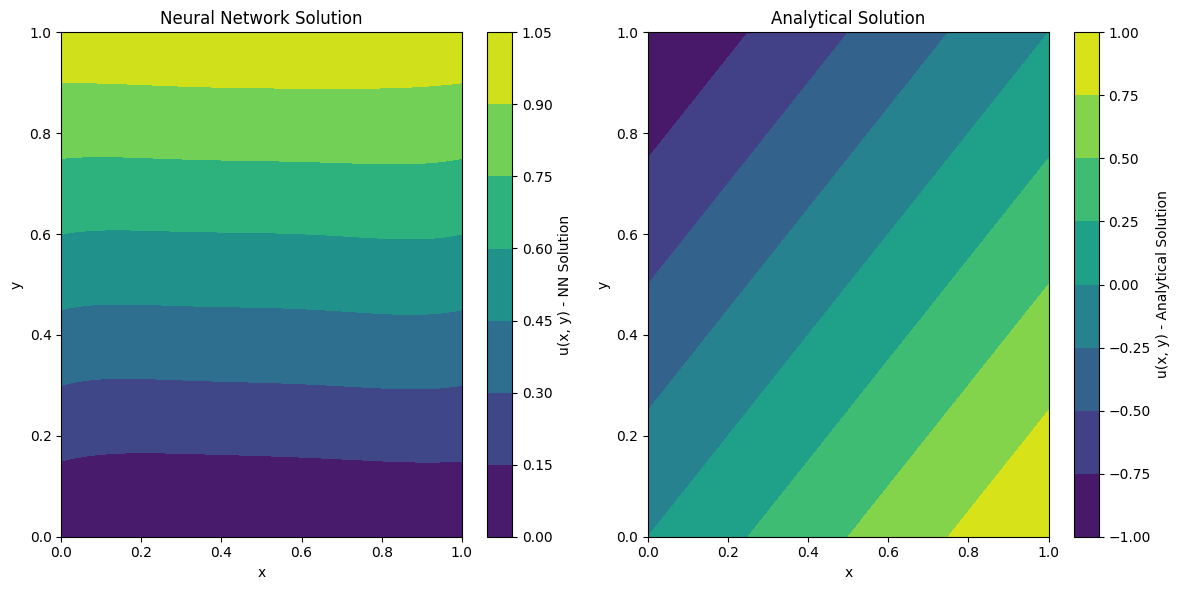

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define x and y values for plotting
x_vals = np.linspace(0, 1, 50)
y_vals = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x_vals, y_vals)

# Get the neural network solution
# Assuming solution_advection is the neural network solution function
U_nn = solution_advection(X, Y, to_numpy=True)

# Define the analytical solution (assuming u(x, y) = x - y for simplicity)
U_ana = X - Y

# Plot the neural network solution
plt.figure(figsize=(12, 6))

# Plot the NN solution
plt.subplot(1, 2, 1)
plt.contourf(X, Y, U_nn, cmap='viridis')
plt.colorbar(label="u(x, y) - NN Solution")
plt.title("Neural Network Solution")
plt.xlabel("x")
plt.ylabel("y")

# Plot the analytical solution
plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_ana, cmap='viridis')
plt.colorbar(label="u(x, y) - Analytical Solution")
plt.title("Analytical Solution")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

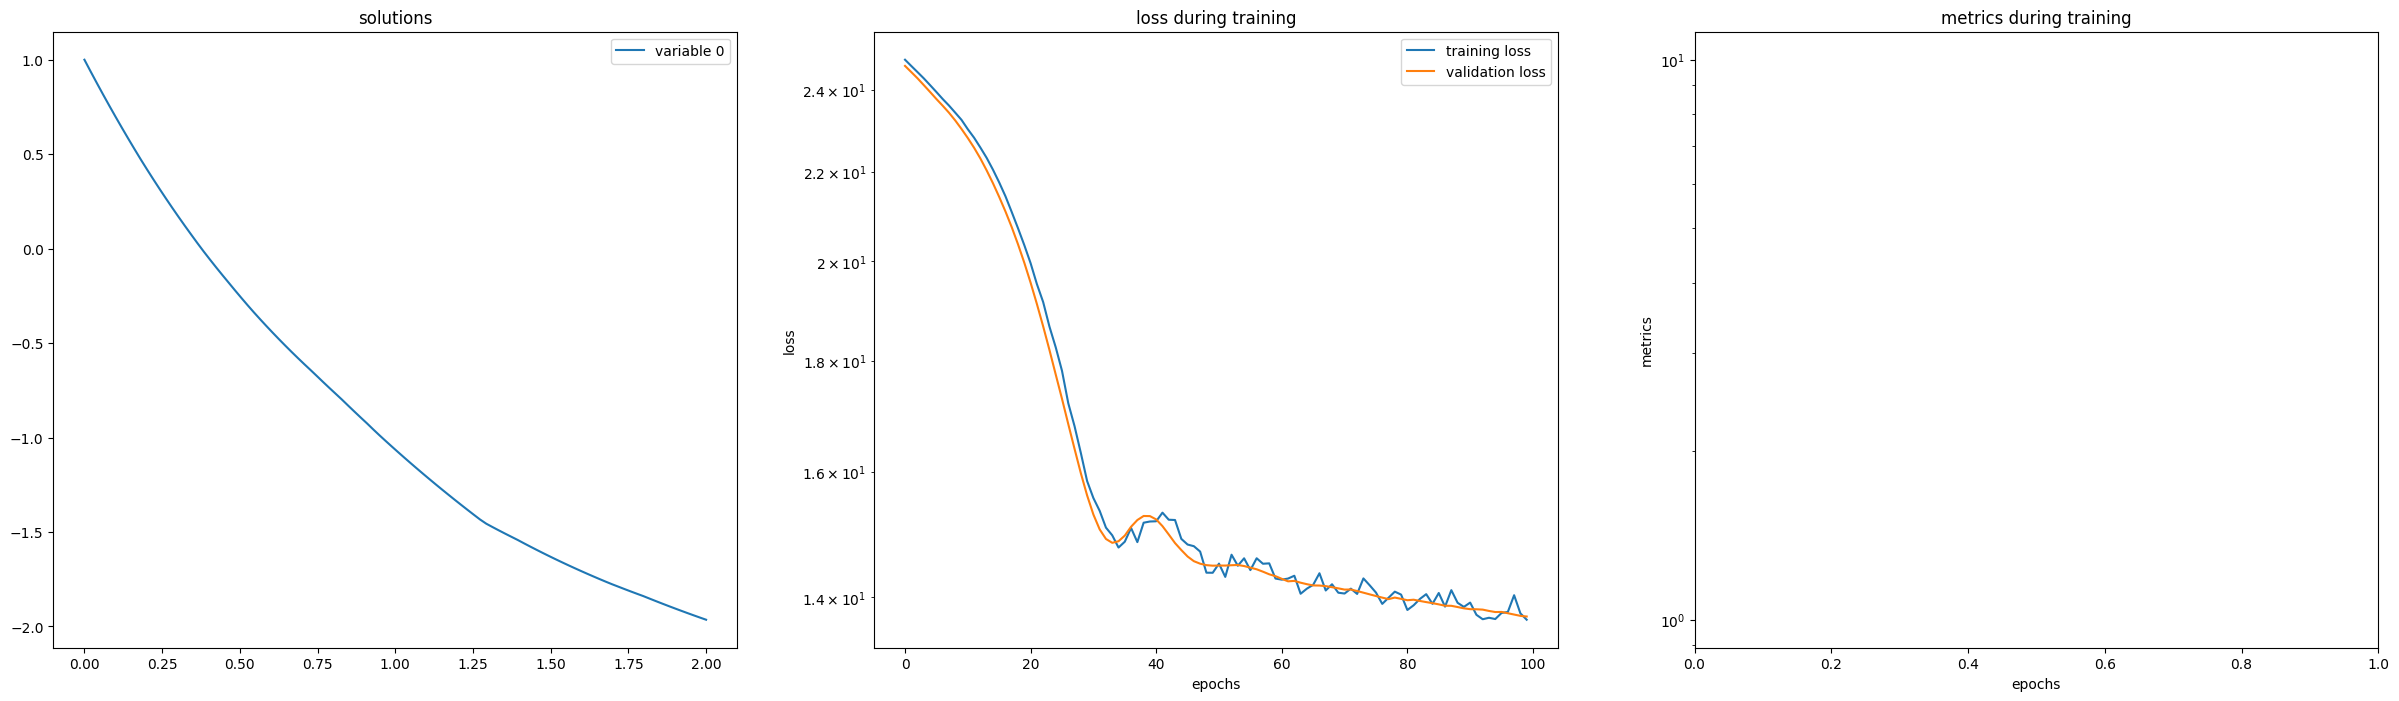

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f5a93ccf6d0>
Traceback (most recent call last):
  File "/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/matplotlib/transforms.py", line 195, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from neurodiffeq import diff
from neurodiffeq.conditions import IVP
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.networks import FCNN

# Define the ODE system: dy/dt = 2y + 3
def formula_1(y, t):
    return [diff(y, t) - 2*y - 3]  # Residual to minimize

# Define the initial condition: y(0) = 1
init_vals_pc = [IVP(t_0=0.0, u_0=1.0)]

# Define the neural network model
net = FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(64, 64, 64, 64),  # 4 hidden layers for a better approximation
    actv=torch.nn.ReLU  # Using ReLU activation for better performance with this problem
)

# Create the optimizer
optimizer = Adam(net.parameters(), lr=0.001)

# Create solver using Solver1D
solver = Solver1D(
    ode_system=formula_1,
    conditions=init_vals_pc,
    t_min=0.0,
    t_max=2,  # You can adjust the time range here
    nets=[net],
    optimizer=optimizer
)
# Let's create a monitor first
monitor = Monitor1D(t_min=0.0, t_max=2, check_every=100)
# ... and turn it into a Callback instance
monitor_callback = monitor.to_callback()
# Fit the solver
solver.fit(max_epochs=3000, callbacks=[monitor_callback])

# Get the predicted solution
solution_pc = solver.get_solution()

# Generate test points for evaluation
t_test = np.linspace(0, 2, 100)

# Get predicted and true values for comparison
y_pred = solution_pc(t_test, to_numpy=True)
y_true = (5 / 2) * np.exp(2 * t_test) - 3 / 2  # Analytical solution: y(t) = 5/2 * exp(2t) - 3/2


In [ ]:
print(y_pred.shape)

(100,)


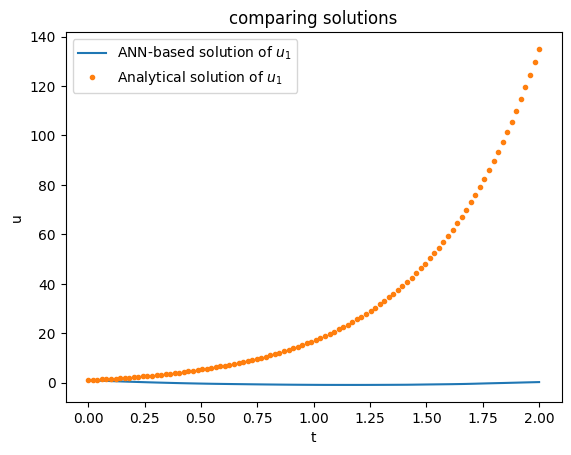

In [ ]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(t_test, y_pred, label='ANN-based solution of $u_1$')
plt.plot(t_test, y_true, '.', label='Analytical solution of $u_1$')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()



## Using Library Torchdyn

In [ ]:
import torchdyn
import torch.nn as nn
from torchdyn.core import NeuralODE
import pytorch_lightning as pl

# Define the vector field (ODE function) as a neural network
f = nn.Sequential(
    nn.Linear(1, 16),  # Input dimension is 1 (time)
    nn.Tanh(),
    nn.Linear(16, 1)  # Output dimension is 1 (the derivative of the function)
)

# Create the NeuralODE model
# Create the time span for ODE solver (this can have more points)
t_span = torch.linspace(0, 23, 100)  # Solve the ODE from 0 to 23 hours, with 100 points in between

model = NeuralODE(f, sensitivity='adjoint', solver='dopri5')

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
import torch.utils.data as data
# Generate some synthetic time data for training
X_train = torch.linspace(0, 23, 24).view(-1, 1)  # Time points (input)
y_train = torch.sin(X_train)  # Let's use sin(t) as the target function (this could be any known function)

# Create a DataLoader for the training data
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

### Training loop using Pytorch lightning

In [ ]:
class Learner(pl.LightningModule):
    def __init__(self, model: nn.Module, t_span: torch.Tensor):
        super(Learner, self).__init__()
        self.model = model
        self.t_span = t_span

    def forward(self, x):
        # Forward pass through the neural ODE model
        t_eval, trajectory = self.model(x, self.t_span)
        return trajectory[-1]  # Return the last point of the solution trajectory

    def training_step(self, batch, batch_idx):
        x, y = batch  # x is time, y is the target function (sin(t) in this case)
        t_eval, trajectory = self.model(x, self.t_span)
        y_hat = trajectory[-1]  # Predicted value (last point)
        loss = nn.MSELoss()(y_hat, y)  # Compute MSE loss between predicted and actual values
        print(f"Epoch: {self.current_epoch}, Loss: {loss.item()}")
        return {'loss': loss}

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return train_loader


In [ ]:
# Initialize the PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=100)

# Create a Learner object and pass it to the trainer
learner = Learner(model=model, t_span=t_span)
trainer.fit(learner)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 49     | train
--------------------------------------------
49        Trainable params
0         Non-trainable params
49        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_eve

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 1109.0167236328125
Epoch: 1, Loss: 865.657958984375
Epoch: 2, Loss: 656.5856323242188
Epoch: 3, Loss: 481.3421936035156
Epoch: 4, Loss: 339.1041564941406
Epoch: 5, Loss: 228.14060974121094
Epoch: 6, Loss: 146.0930633544922
Epoch: 7, Loss: 88.47811889648438
Epoch: 8, Loss: 50.2775993347168
Epoch: 9, Loss: 26.511354446411133
Epoch: 10, Loss: 13.101909637451172
Epoch: 11, Loss: 6.059991359710693
Epoch: 12, Loss: 2.709948778152466
Epoch: 13, Loss: 1.2935850620269775
Epoch: 14, Loss: 0.8220627903938293
Epoch: 15, Loss: 0.7124078869819641
Epoch: 16, Loss: 0.7021359801292419
Epoch: 17, Loss: 0.7066372036933899
Epoch: 18, Loss: 0.7091347575187683
Epoch: 19, Loss: 0.708679735660553
Epoch: 20, Loss: 0.706270158290863
Epoch: 21, Loss: 0.70269376039505
Epoch: 22, Loss: 0.6984255313873291
Epoch: 23, Loss: 0.6937429308891296
Epoch: 24, Loss: 0.6888127326965332
Epoch: 25, Loss: 0.6837399005889893
Epoch: 26, Loss: 0.6785941123962402
Epoch: 27, Loss: 0.6734232306480408
Epoch: 28, Loss: 

`Trainer.fit` stopped: `max_epochs=100` reached.


tensor([ 0.0000, -0.0187, -0.0336, -0.0454, -0.0548, -0.0622, -0.0681, -0.0728,
        -0.0765, -0.0795, -0.0818, -0.0837, -0.0852, -0.0863, -0.0873, -0.0880,
        -0.0886, -0.0891, -0.0894, -0.0897, -0.0900, -0.0901, -0.0903, -0.0904,
        -0.0905, -0.0906, -0.0906, -0.0907, -0.0907, -0.0907, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908, -0.0908,
        -0.0908, -0.0908, -0.0908, -0.09

Text(0.5, 1.0, 'Dimension 0')

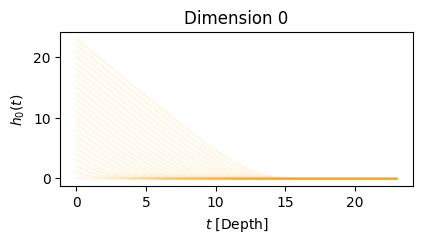

In [ ]:
import matplotlib.pyplot as plt


t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()
print(trajectory[:, 0, 0])
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
for i in range(24):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(y_train[i])], alpha=.1)
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")

ax0.set_title("Dimension 0")


In [ ]:
# Generate an hourly dataset (0 to 23:00)
# Example: Let's assume X is the time of day (0, 1, ..., 23) and y is some related output for each hour.
n_samples = 24  # Number of hourly samples
X = np.arange(n_samples).reshape(-1, 1)  # Hour of the day (0 to 23)
y = np.sin(np.linspace(0, 2 * np.pi, n_samples))  # Some output (e.g., a sine wave, can be your target data)

# Convert the dataset into PyTorch tensors
X_train = torch.Tensor(X)
y_train = torch.Tensor(y)

# Create a DataLoader
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

In [ ]:
# Define a simple neural network as the vector field for the NeuralODE
f = nn.Sequential(
    nn.Linear(1, 16),  # Input dimension is 1 (time of the day)
    nn.Tanh(),
    nn.Linear(16, 1)   # Output dimension is 1 (the target value for that hour)
)

# Define the t_span, which represents the time span (in this case, from 0 to 23:00)
t_span = torch.linspace(0, 23, 100)  # 100 time steps between 0 and 23 hours

# Define the NeuralODE model
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5')

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
# Use PyTorch Lightning to define the training loop
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]  # Select the last point of the trajectory
        loss = nn.MSELoss()(y_hat, y)  # Use MSE loss for regression
        print(f"Epoch: {self.current_epoch}, pred: {y_hat}, Loss: {loss.item()}")
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [ ]:
# Train the model using PyTorch Lightning
learn = Learner(t_span, model)
trainer = pl.Trainer(min_epochs=100, max_epochs=300)
trainer.fit(learn)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 49     | train
--------------------------------------------
49        Trainable params
0         Non-trainable params
49        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_eve

Training: |          | 0/? [00:00<?, ?it/s]

/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, pred: tensor([[24.6304],
        [25.6173],
        [18.7082],
        [15.7255],
        [14.7228],
        [ 9.5444],
        [10.6254],
        [20.6846],
        [12.6973],
        [17.7172],
        [ 8.3785],
        [21.6713],
        [23.6439],
        [ 7.0058],
        [ 1.0082],
        [16.7233],
        [22.6576],
        [13.7139],
        [11.6702],
        [19.6971],
        [ 5.1132],
        [ 2.3434],
        [26.6048],
        [27.5929]], grad_fn=<SelectBackward0>), Loss: 306.27105712890625
Epoch: 1, pred: tensor([[ 9.5586],
        [ 1.5969],
        [ 8.5108],
        [21.6310],
        [19.6422],
        [ 6.3141],
        [ 5.0649],
        [16.6532],
        [12.6337],
        [ 0.1604],
        [10.5925],
        [ 0.1986],
        [17.6509],
        [15.6535],
        [14.6509],
        [ 3.5259],
        [23.6191],
        [18.6471],
        [22.6250],
        [20.6368],
        [ 7.4386],
        [13.6447],
        [11.6168],
        [ 0.4053]], g

`Trainer.fit` stopped: `max_epochs=300` reached.


[[0.0000000e+00]
 [4.0343799e-08]
 [7.2547735e-08]
 [9.2548362e-08]
 [1.0838397e-07]
 [1.1184586e-07]
 [1.1530774e-07]
 [1.1876963e-07]
 [1.2143595e-07]
 [1.2316688e-07]
 [1.2489782e-07]
 [1.2662876e-07]
 [1.2835970e-07]
 [1.3009064e-07]
 [1.3182158e-07]
 [1.3355252e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-07]
 [1.3561481e-0

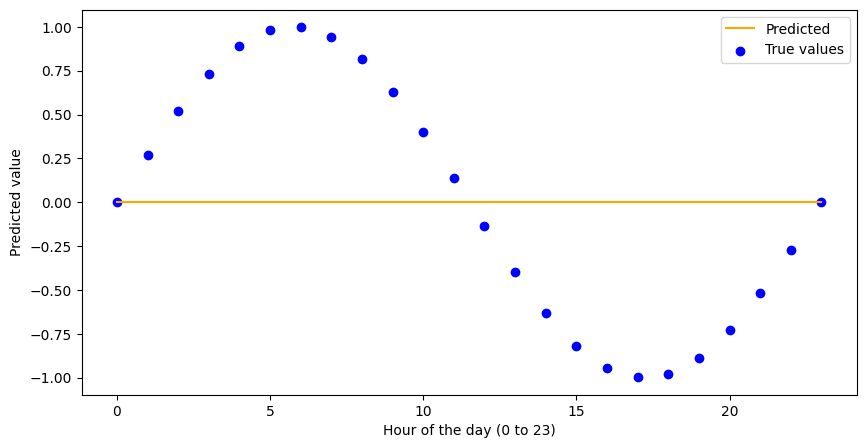

In [ ]:
# After training, evaluate the model
t_eval, trajectory = model(X_train, t_span)

# Plot the training results
trajectory = trajectory.detach().cpu().numpy()
print(trajectory[:, 0])

fig = plt.figure(figsize=(10, 5))
plt.plot(t_span.numpy(), trajectory[:, 0], label="Predicted", color="orange")
plt.scatter(X, y, label="True values", color="blue")
plt.xlabel("Hour of the day (0 to 23)")
plt.ylabel("Predicted value")
plt.legend()
plt.show()

## Using Scipy (Taylor series approx)

### ODE book example 1.1.8

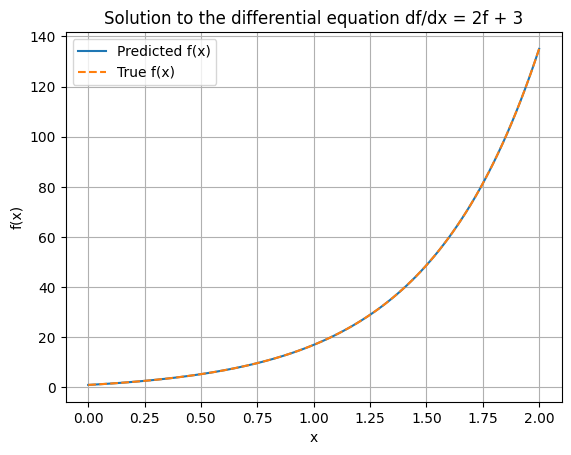

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE (dy/dx = 2*y + 3)
def ode(x, f):
    return 2 * f + 3

x_max = 2

# Define the initial condition
initial_condition = [1]  # f(0) = 1

# Set up the range of x values
x_span = (0, x_max)

# Solve the ODE
solution = solve_ivp(ode, x_span, initial_condition, t_eval=np.linspace(0, x_max, 100))

# Define the true function
def true_function(x):
    return 5/2 * np.exp(2*x) - 3/2

# Plot the solution
plt.plot(solution.t, solution.y[0], label="Predicted f(x)")

# Plot the true function
x_values = np.linspace(0, x_max, 100)
plt.plot(x_values, true_function(x_values), label="True f(x)", linestyle='dashed')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Solution to the differential equation df/dx = 2f + 3')
plt.legend()
plt.grid(True)
plt.show()

### ODE book example 1.5.4

Predicted t1: 92.1542927401
Analytical t1: 92.1034037198


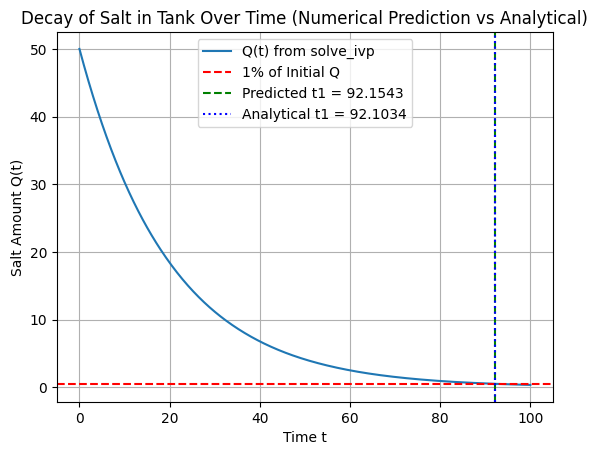

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.optimize import fsolve

# Given parameters
V0 = 100  # Initial volume of water (arbitrary unit)
r = 5     # Flow rate (arbitrary unit)
Q0 = 50   # Initial salt amount
t_max = 100

# Define the ODE dQ/dt = - (r/V0) * Q
def dQ_dt(t, Q):
    return - (r / V0) * Q

# Solve the ODE from t=0 to a sufficiently large time
solution = solve_ivp(dQ_dt, (0, t_max), [Q0], t_eval=np.linspace(0, t_max, 500))

# Find the time t1 when Q(t1) = Q0 / 100
def condition(t):
    return Q0 * np.exp(-r * t / V0) - Q0 / 100



# # Solve for t1 using fsolve
# t1_guess = 10  # Initial guess
# t1 = fsolve(condition, t1_guess)[0]  # Get the first solution


# print(f"Time t1 when concentration reaches 1% of initial: {t1:.10f}")

# Extract time (solution.t) and Q values (solution.y[0])
t_values = solution.t
Q_values = solution.y[0]

# Find the predicted t1 using interpolation
Q_target = Q0 / 100  # 1% of initial Q
t1_predicted = np.interp(Q_target, Q_values[::-1], t_values[::-1])  # Reverse to ensure decreasing order


print(f"Predicted t1: {t1_predicted:.10f}")
# Compute the analytical t1 for comparison
t1_analytical = (V0 / r) * np.log(100)
print(f"Analytical t1: {t1_analytical:.10f}")


# Plot the solution
plt.plot(solution.t, solution.y[0], label="Q(t) from solve_ivp")
plt.axhline(Q0 / 100, color='r', linestyle='--', label="1% of Initial Q")
plt.axvline(t1_predicted, color='g', linestyle='--', label=f"Predicted t1 = {t1_predicted:.4f}")
plt.axvline(t1_analytical, color='b', linestyle=':', label=f"Analytical t1 = {t1_analytical:.4f}")
plt.xlabel("Time t")
plt.ylabel("Salt Amount Q(t)")
plt.title("Decay of Salt in Tank Over Time (Numerical Prediction vs Analytical)")
plt.legend()
plt.grid(True)
plt.show()

### ODE book example 2.6.1

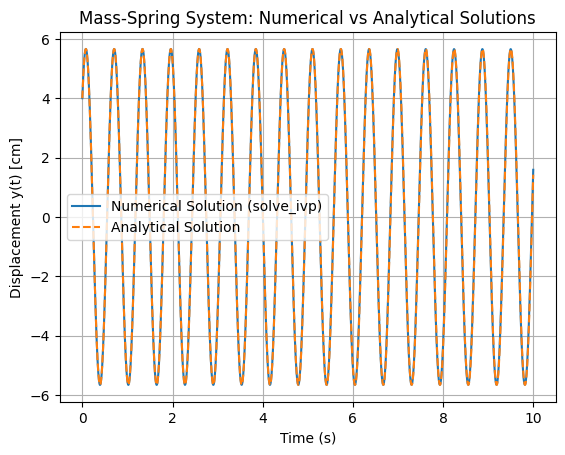

Predicted:
[4.         4.03980355 4.07920347 ... 1.47862405 1.53310234 1.587422  ]
Analytical:
[4.         4.0398033  4.07920253 ... 1.3140297  1.36898978 1.42381292]
Predicted time when y(t) = 0: 0.2350 seconds
Analytical time when y(t) = 0: 0.3142 seconds


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Given parameters
m = 50    # mass in grams
g = 1000  # acceleration due to gravity in cm/s^2
delta_l = 6  # spring stretch in cm
k = (30 * g) / delta_l  # spring constant in gr/s^2
omega_0 = np.sqrt(k / m)  # natural frequency in 1/s
A = 4 * np.sqrt(2)  # amplitude
phi = np.pi / 4  # phase shift

# Define the differential equation m * y'' + k * y = 0
def mass_spring(t, y):
    return [y[1], -(k / m) * y[0]]

# Initial conditions: y(0) = 4 cm, y'(0) = 40 cm/s
y0 = [4, 40]

# Solve the ODE using solve_ivp
t_max = 10  # max time for solution
t_eval = np.linspace(0, t_max, 10000)  # time points to evaluate the solution
solution = solve_ivp(mass_spring, (0, t_max), y0, t_eval=t_eval)

# Analytical solution: y(t) = A * cos(omega_0 * t - phi)
def analytical_solution(t):
    return A * np.cos(omega_0 * t - phi)

# Plot the results
plt.plot(solution.t, solution.y[0], label="Numerical Solution (solve_ivp)")
plt.plot(solution.t, analytical_solution(solution.t), '--', label="Analytical Solution")
plt.xlabel("Time (s)")
plt.ylabel("Displacement y(t) [cm]")
plt.title("Mass-Spring System: Numerical vs Analytical Solutions")
plt.legend()
plt.grid(True)
plt.show()

print("Predicted:")
print(solution.y[0])
print("Analytical:")
print(analytical_solution(solution.t))

# Print predicted and analytical values of t for the displacement y(t) = 0
# The displacement crosses zero at y(t) = 0. We can find this using the solution.
# Find the time t when y(t) crosses zero (i.e., y(t) changes sign)
zero_crossings = np.where(np.diff(np.sign(solution.y[0])))[0]  # Indices where sign changes
t_cross_zero_pred = solution.t[zero_crossings[0]]  # First zero crossing time
t_cross_zero_analytical = np.pi / 10  # From analytical formula: cos(ω_0 t - φ) = 0, thus t = π / ω_0

print(f"Predicted time when y(t) = 0: {t_cross_zero_pred:.4f} seconds")
print(f"Analytical time when y(t) = 0: {t_cross_zero_analytical:.4f} seconds")
